In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import ttest_ind
from gprofiler import GProfiler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

In [3]:
# Load your dataset
df = pd.read_excel("ProteinList-Final-MaxLFQ_2D culture.xlsx")

# Rename sample columns
rename_dict = {
    "241016mk-06_BM_EXO_1_Slot1-01_1_13877": "BM1",
    "241016mk-07_BM_EXO_2_Slot1-02_1_13878": "BM2",
    "241016mk-08_BM_EXO_3_Slot1-03_1_13879": "BM3",
    "241016mk-11_iMSC_EXO_1_Slot1-04_1_13882": "iMSC1",
    "241016mk-12_iMSC_EXO_2_Slot1-05_1_13889": "iMSC2",
    "241016mk-15_iMSC_EXO_3_Slot1-06_1_13892": "iMSC3",
    "241016mk-18_iPS_EXO_1_Slot1-07_1_13895": "iPS1",
    "241016mk-21_iPS_EXO_2_Slot1-08_1_13898": "iPS2",
    "241016mk-24_iPS_EXO_3_Slot1-09_1_13901": "iPS3",
}

df = df.rename(columns=rename_dict)
gene_names = df["Genes"]  # Adjust if the column name differs

# Now extract intensity columns with new names
data_columns = list(rename_dict.values())
df_filtered = df[data_columns].copy()


#  Filter out proteins with too many missing values
Remove proteins with >50% missing values across samples.



In [4]:
df_filtered = df_filtered.dropna(axis=0) 
#df_filtered = df_filtered.dropna(thresh=len(data_columns) * 0.5)
df_filtered

,BM1,BM2,BM3,iMSC1,iMSC2,iMSC3,iPS1,iPS2,iPS3
66,13774.0,16508.70,13940.00,192886.00,18096.70,24501.7,113138.00,94018.80,85855.90
72,57156.6,83462.20,50340.20,18292.90,22856.10,28510.7,56097.70,35461.60,45610.20
77,83632.4,100454.00,85917.60,30236.50,41204.60,51499.6,52000.40,36009.20,38820.50
78,64733.9,50624.30,60683.80,29179.70,31029.10,44084.7,51548.10,29271.50,31445.30
82,10830.8,8624.76,10157.20,15361.30,22285.80,85747.4,6280.26,3150.47,3098.76
...,...,...,...,...,...,...,...,...,...
3948,17958.6,32158.50,17617.90,24490.30,17975.40,33101.7,81733.10,53296.80,52428.30
3962,16975.4,14511.40,15604.10,9473.66,8727.43,17643.0,61791.50,46202.90,46499.60
4071,179495.0,159454.00,325841.00,108477.00,151362.00,47616.6,10372.00,13473.90,4476.48
4175,17205.5,5570.33,3911.57,14963.10,5331.70,16214.0,176098.00,161068.00,133907.00


# Impute missing values
Replace remaining NaNs with the minimum detected value per protein (common in proteomics).


In [ ]:
#df_filtered = df_filtered.apply(lambda x: x.fillna(x.min()), axis=1)
#df_filtered

# 3) Remove proteins with near-zero variance
PCA works best when variation is present. Remove proteins with little to no expression change.

In [5]:
selector = VarianceThreshold(threshold=1.0)  # Adjust as needed
filtered_data = selector.fit_transform(df_filtered)
df_filtered

,BM1,BM2,BM3,iMSC1,iMSC2,iMSC3,iPS1,iPS2,iPS3
66,13774.0,16508.70,13940.00,192886.00,18096.70,24501.7,113138.00,94018.80,85855.90
72,57156.6,83462.20,50340.20,18292.90,22856.10,28510.7,56097.70,35461.60,45610.20
77,83632.4,100454.00,85917.60,30236.50,41204.60,51499.6,52000.40,36009.20,38820.50
78,64733.9,50624.30,60683.80,29179.70,31029.10,44084.7,51548.10,29271.50,31445.30
82,10830.8,8624.76,10157.20,15361.30,22285.80,85747.4,6280.26,3150.47,3098.76
...,...,...,...,...,...,...,...,...,...
3948,17958.6,32158.50,17617.90,24490.30,17975.40,33101.7,81733.10,53296.80,52428.30
3962,16975.4,14511.40,15604.10,9473.66,8727.43,17643.0,61791.50,46202.90,46499.60
4071,179495.0,159454.00,325841.00,108477.00,151362.00,47616.6,10372.00,13473.90,4476.48
4175,17205.5,5570.33,3911.57,14963.10,5331.70,16214.0,176098.00,161068.00,133907.00


# 4) Log-transform the data 
to normalize skewed distributions

In [6]:
filtered_data = pd.DataFrame(filtered_data, index=df_filtered.index, columns=data_columns)
filtered_data["Genes"] = gene_names.loc[filtered_data.index]  # Reattach gene names
# Move "Gene Name" to index for heatmap
filtered_data.set_index("Genes", inplace=True)

# Log2 transform for better visualization
filtered_data = np.log2(filtered_data + 1)
filtered_data.to_csv("filtered_data.csv")
filtered_data

,BM1,BM2,BM3,iMSC1,iMSC2,iMSC3,iPS1,iPS2,iPS3
Genes,,,,,,,,,
ACLY,13.749765,14.011026,13.767046,17.557396,14.143519,14.580653,16.787737,16.520677,16.389646
APEH,15.802658,16.348853,15.619452,14.159075,14.480355,14.799266,15.775680,15.114011,15.477101
ACTN1,16.351792,16.616190,16.390683,14.884051,15.330553,15.652302,15.666263,15.136118,15.244568
ACTN4,15.982256,15.627571,15.889048,14.832727,14.921381,15.428023,15.653660,14.837258,14.940603
ADAM10,13.402985,13.074436,13.310357,13.907107,14.443902,16.387822,12.616838,11.621809,11.597941
...,...,...,...,...,...,...,...,...,...
U2AF1,14.132468,14.972957,14.104836,14.579982,14.133817,15.014661,16.318650,15.701788,15.678086
UBA1,14.051243,13.824999,13.929730,13.209858,13.091506,14.106890,15.915144,15.495727,15.504962
VIM,17.453592,17.282790,18.313813,16.727043,17.207653,15.539207,13.340546,13.717987,12.128471


## Perform PCA


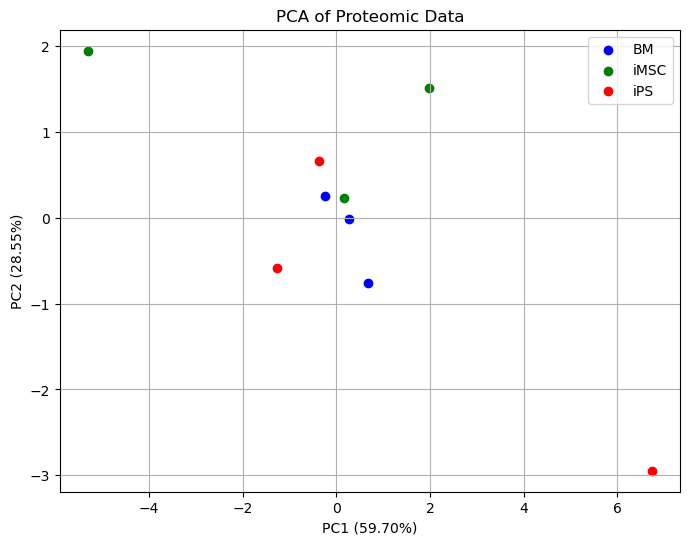

In [7]:
# Standardize the data
scaler = StandardScaler()
protein_data_scaled = scaler.fit_transform(filtered_data)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(protein_data_scaled)

# Define colors for groups
sample_groups = ["BM"] * 3 + ["iMSC"] * 3 + ["iPS"] * 3
colors = {"BM": "blue", "iMSC": "green", "iPS": "red"}

# Track plotted groups to avoid duplicate legend entries
plotted_groups = set()

plt.figure(figsize=(8, 6))
for i, label in enumerate(data_columns):
    group = sample_groups[i]
    if group not in plotted_groups:  # Add label only once per group
        plt.scatter(pca_result[i, 0], pca_result[i, 1], color=colors[group], label=group)
        plotted_groups.add(group)
    else:
        plt.scatter(pca_result[i, 0], pca_result[i, 1], color=colors[group])

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.title("PCA of Proteomic Data")
plt.legend()
plt.grid(True)
plt.show()


## Hierarchical Clustering & Heatmap

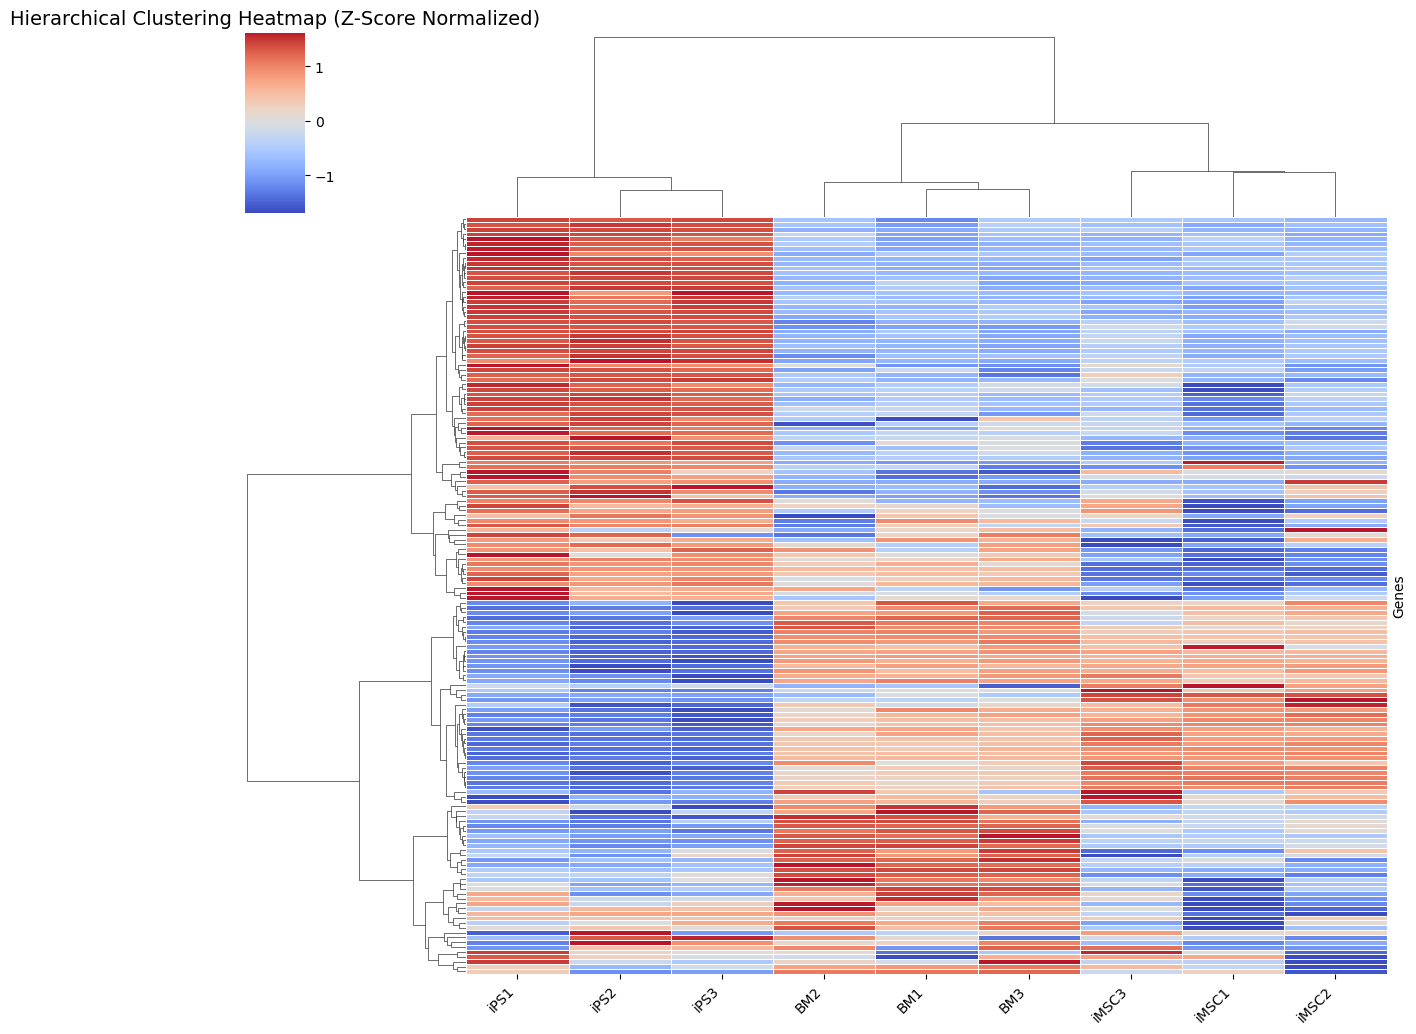

In [8]:
# Apply Z-score normalization (row-wise, across samples)
filtered_data_zscore = filtered_data.apply(zscore, axis=1)

# Remove NaNs (sometimes all-zero rows cause NaNs after z-score)
filtered_data_zscore = filtered_data_zscore.dropna()


# Create hierarchical clustering heatmap with Z-scored data
g = sns.clustermap(
    filtered_data_zscore,  # Use Z-scored data
    method="ward",
    cmap="coolwarm",
    center=0,  # Ensure colors are balanced around zero
    robust=True,  # Reduce impact of extreme values
    linewidths=0.5,
    xticklabels=True,  
    yticklabels=False,  # Hide gene names
    figsize=(12, 10)
)

# Improve X-axis label visibility
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", fontsize=10)

plt.title("Hierarchical Clustering Heatmap (Z-Score Normalized)", fontsize=14)
plt.show()



In [9]:
# Define sample groups
BM = filtered_data.loc[:, ["BM1", "BM2", "BM3"]]
iMSC = filtered_data.loc[:, ["iMSC1", "iMSC2", "iMSC3"]]
iPS = filtered_data.loc[:, ["iPS1", "iPS2", "iPS3"]]

# Compute fold change (mean expression ratio) and p-values
diff_expr_results = {}
for protein in filtered_data.index:  # Use filtered_data.index instead of protein_data.index
    fold_change_BM_iPS = BM.loc[protein].mean() / iPS.loc[protein].mean()
    p_value_BM_iPS = ttest_ind(BM.loc[protein], iPS.loc[protein], equal_var=False).pvalue

    fold_change_iMSC_iPS = iMSC.loc[protein].mean() / iPS.loc[protein].mean()
    p_value_iMSC_iPS = ttest_ind(iMSC.loc[protein], iPS.loc[protein], equal_var=False).pvalue

    diff_expr_results[protein] = [fold_change_BM_iPS, p_value_BM_iPS, fold_change_iMSC_iPS, p_value_iMSC_iPS]

# Convert to DataFrame
diff_expr_df = pd.DataFrame.from_dict(diff_expr_results, orient='index',
                                      columns=["FoldChange_BM_iPS", "PValue_BM_iPS", "FoldChange_iMSC_iPS", "PValue_iMSC_iPS"])

# Apply significance threshold (p-value < 0.05) for BM vs iPS and iMSC vs iPS
significant_proteins = diff_expr_df[(diff_expr_df["PValue_BM_iPS"] < 0.05) | (diff_expr_df["PValue_iMSC_iPS"] < 0.05)]

# Save results
diff_expr_df.to_csv("differential_expression_results.csv")
print("Significant proteins:", significant_proteins.shape[0])


Significant proteins: 131


C:\Users\drzia\AppData\Local\Temp\ipykernel_9904\2605190905.py:9: RuntimeWarning: invalid value encountered in scalar divide
  fold_change_BM_iPS = BM.loc[protein].mean() / iPS.loc[protein].mean()
C:\Users\drzia\AppData\Local\Temp\ipykernel_9904\2605190905.py:12: RuntimeWarning: invalid value encountered in scalar divide
  fold_change_iMSC_iPS = iMSC.loc[protein].mean() / iPS.loc[protein].mean()


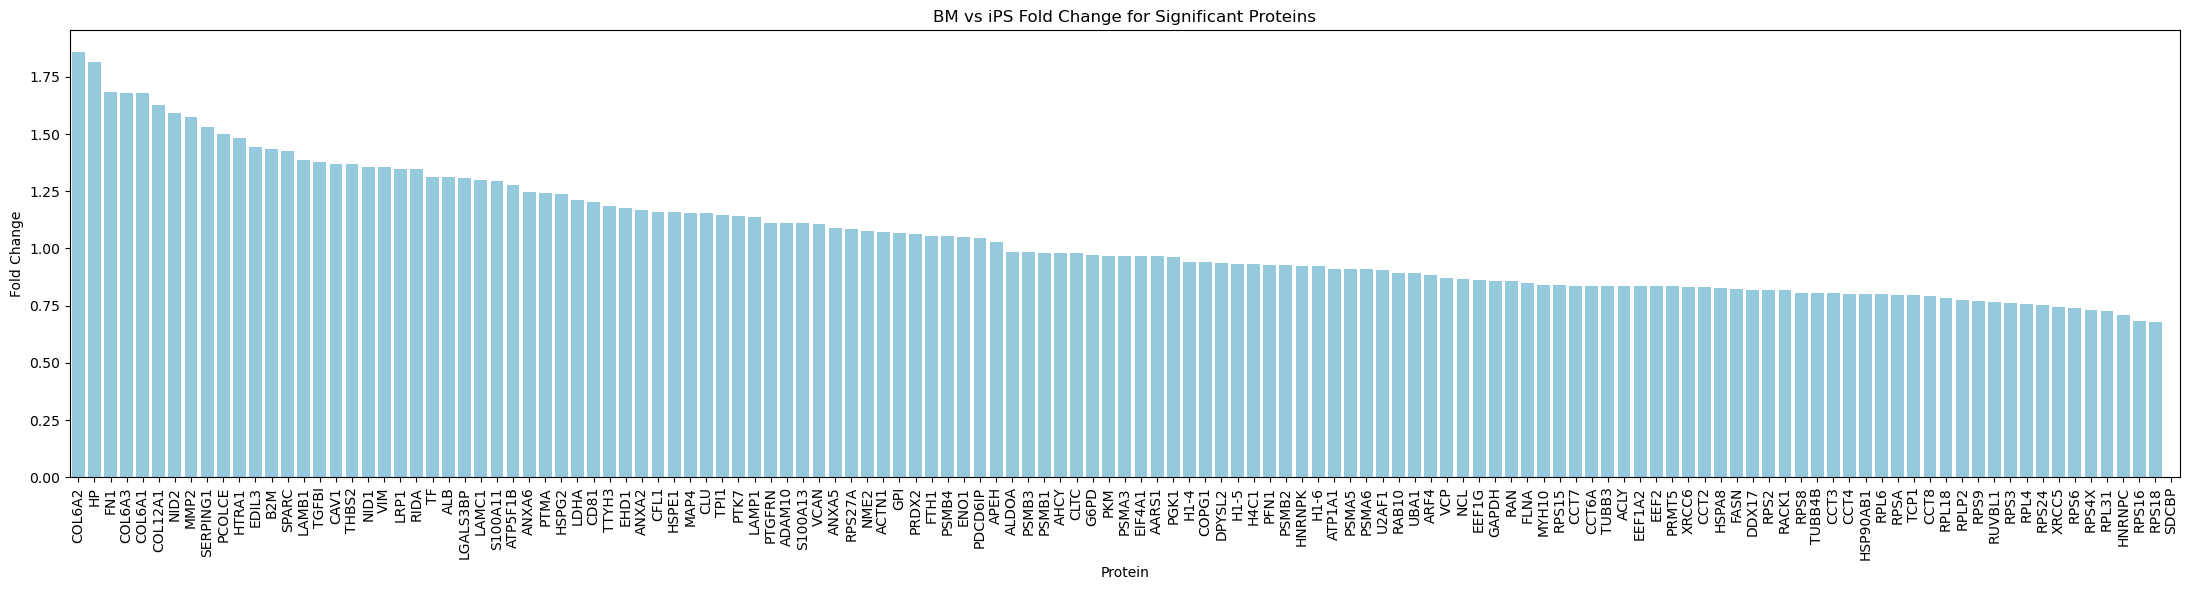

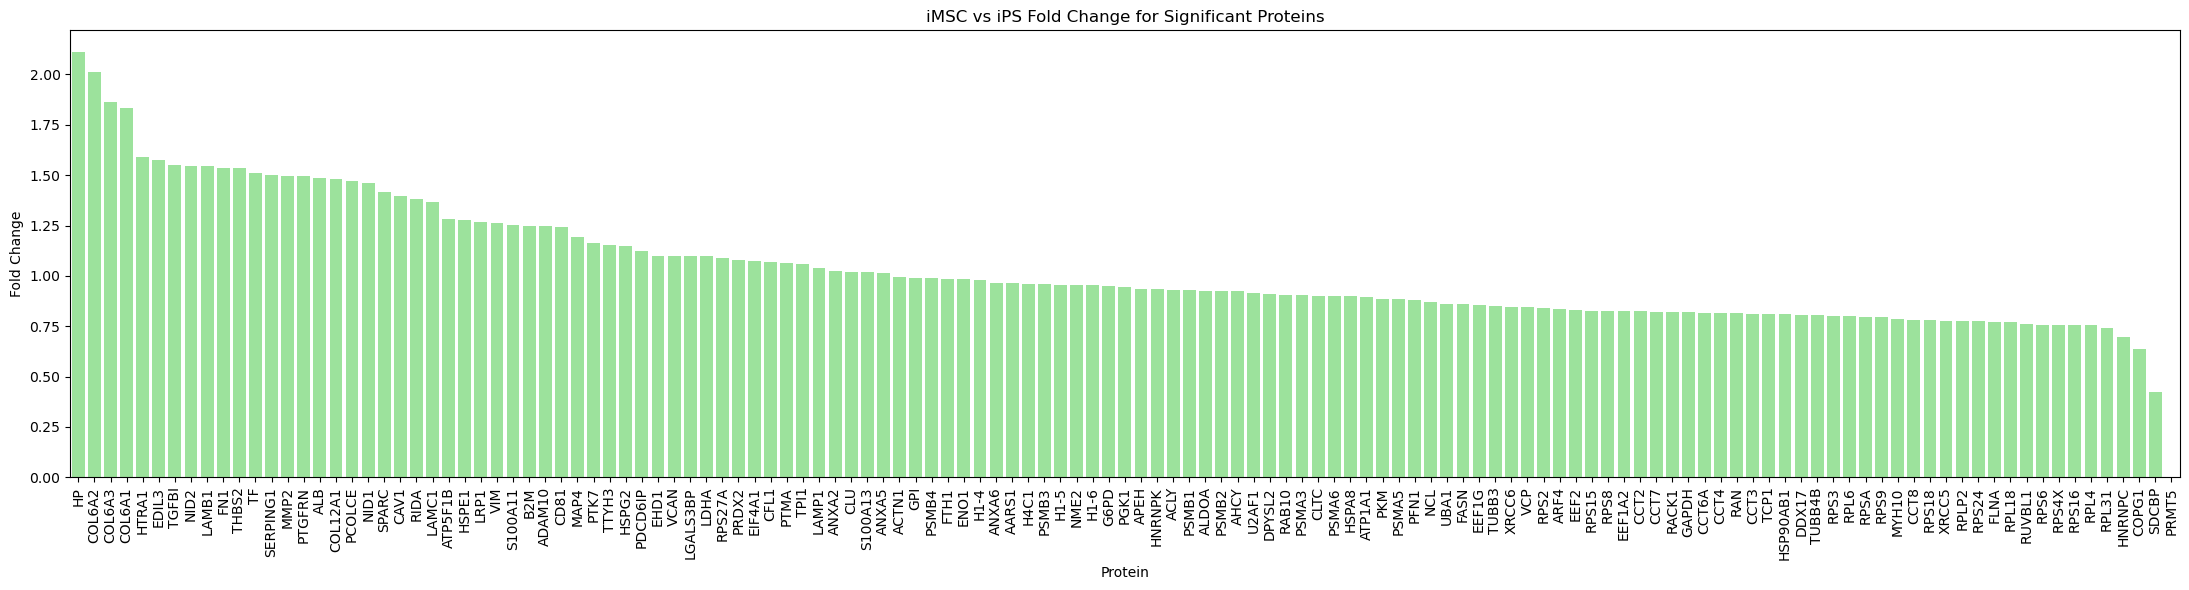

In [10]:

# Sort significant proteins by FoldChange_BM_iPS
significant_proteins_sorted_BM_iPS = significant_proteins.sort_values(by="FoldChange_BM_iPS", ascending=False)

# Plot fold changes for BM vs iPS
plt.figure(figsize=(22, 6))

# Select the fold change values for BM vs iPS
significant_proteins_fc_BM_iPS = significant_proteins_sorted_BM_iPS[["FoldChange_BM_iPS"]].reset_index()

# Plot using seaborn
sns.barplot(data=significant_proteins_fc_BM_iPS, x='index', y='FoldChange_BM_iPS', color='skyblue')

# Rotate labels for better readability
plt.xticks(rotation=90)

# Title and labels
plt.title('BM vs iPS Fold Change for Significant Proteins')
plt.xlabel('Protein')
plt.ylabel('Fold Change')

# Show plot
plt.tight_layout()
plt.show()

# Sort significant proteins by FoldChange_iMSC_iPS
significant_proteins_sorted_iMSC_iPS = significant_proteins.sort_values(by="FoldChange_iMSC_iPS", ascending=False)

# Plot fold changes for iMSC vs iPS
plt.figure(figsize=(22, 6))

# Select the fold change values for iMSC vs iPS
significant_proteins_fc_iMSC_iPS = significant_proteins_sorted_iMSC_iPS[["FoldChange_iMSC_iPS"]].reset_index()

# Plot using seaborn
sns.barplot(data=significant_proteins_fc_iMSC_iPS, x='index', y='FoldChange_iMSC_iPS', color='lightgreen')

# Rotate labels for better readability
plt.xticks(rotation=90)

# Title and labels
plt.title('iMSC vs iPS Fold Change for Significant Proteins')
plt.xlabel('Protein')
plt.ylabel('Fold Change')

# Show plot
plt.tight_layout()
plt.show()


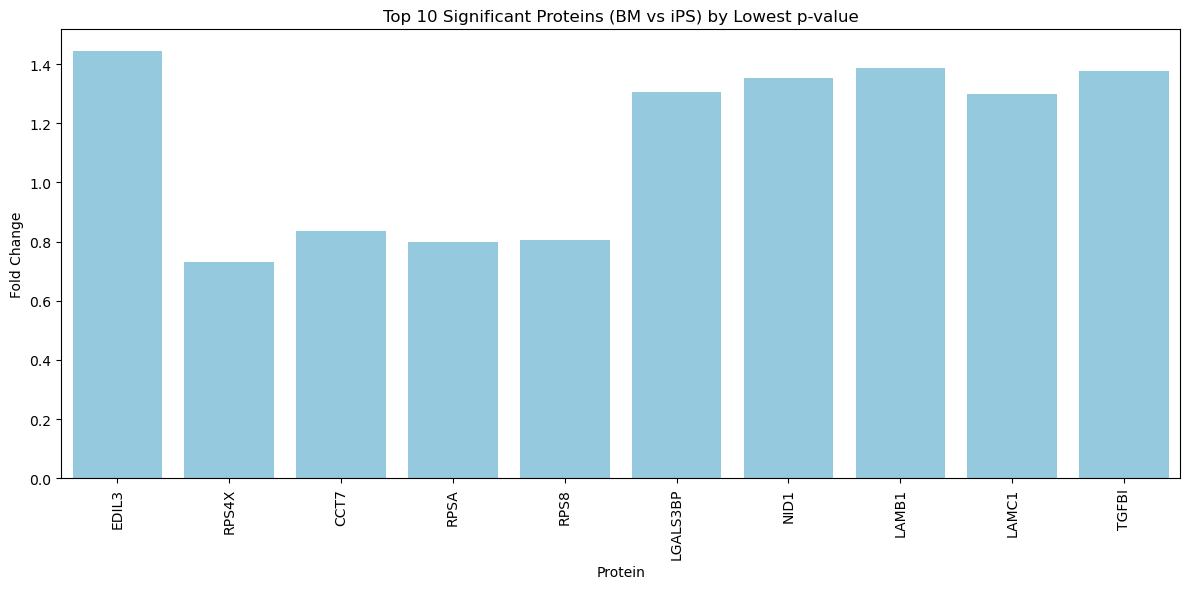

In [11]:
# Sort by the lowest p-value for BM vs iPS and iMSC vs iPS
top_proteins = significant_proteins.sort_values(by=["PValue_BM_iPS"]).head(10)

# Plot fold changes for the top 10 significant proteins (BM vs iPS)
plt.figure(figsize=(12, 6))

# Select the fold change values for BM vs iPS
top_proteins_fc_BM_iPS = top_proteins[["FoldChange_BM_iPS"]].reset_index()

# Plot using seaborn
sns.barplot(data=top_proteins_fc_BM_iPS, x='index', y='FoldChange_BM_iPS', color='skyblue')

# Rotate labels for better readability
plt.xticks(rotation=90)

# Title and labels
plt.title('Top 10 Significant Proteins (BM vs iPS) by Lowest p-value')
plt.xlabel('Protein')
plt.ylabel('Fold Change')

# Show plot
plt.tight_layout()
plt.show()



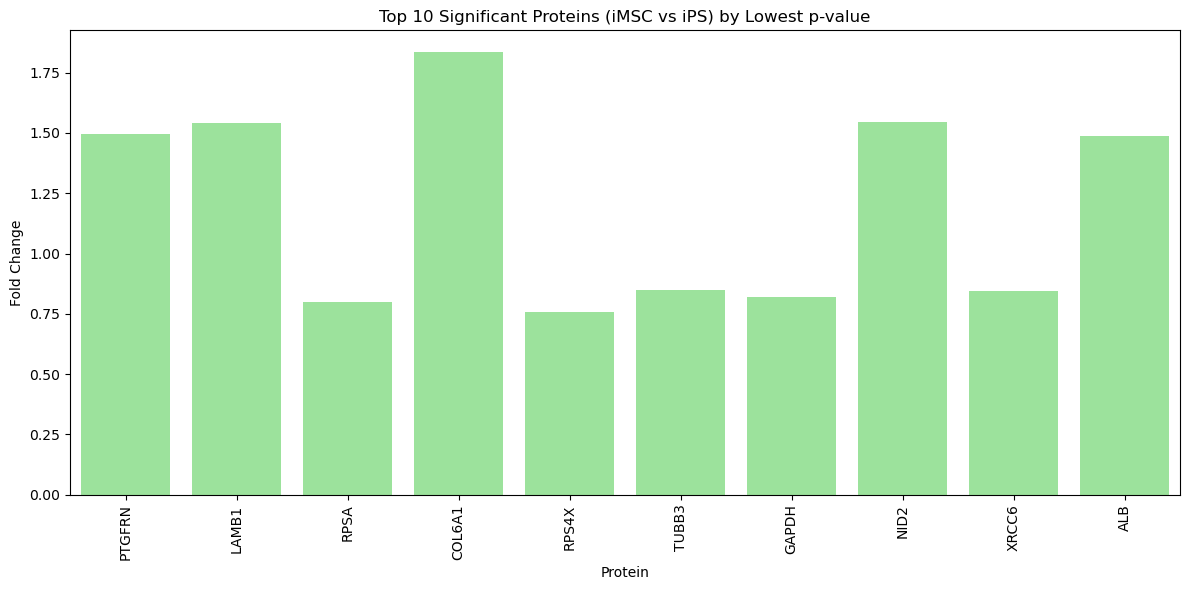

In [12]:
# Sort by the lowest p-value for BM vs iPS and iMSC vs iPS
top_proteins = significant_proteins.sort_values(by=["PValue_iMSC_iPS"]).head(10)


# Plot fold changes for the top 10 significant proteins (iMSC vs iPS)
plt.figure(figsize=(12, 6))

# Select the fold change values for iMSC vs iPS
top_proteins_fc_iMSC_iPS = top_proteins[["FoldChange_iMSC_iPS"]].reset_index()

# Plot using seaborn
sns.barplot(data=top_proteins_fc_iMSC_iPS, x='index', y='FoldChange_iMSC_iPS', color='lightgreen')

# Rotate labels for better readability
plt.xticks(rotation=90)

# Title and labels
plt.title('Top 10 Significant Proteins (iMSC vs iPS) by Lowest p-value')
plt.xlabel('Protein')
plt.ylabel('Fold Change')

# Show plot
plt.tight_layout()
plt.show()

In [13]:
# Filter significant proteins for BM vs iPS (p-value ≤ 0.05)
significant_BM_iPS = significant_proteins[significant_proteins["PValue_BM_iPS"] <= 0.05]
significant_BM_iPS_list = significant_BM_iPS.index.tolist()

# Run GO analysis for BM vs iPS
gp_BM_iPS = GProfiler(return_dataframe=True)
go_results_BM_iPS = gp_BM_iPS.profile(organism="hsapiens", query=significant_BM_iPS_list)

# Show top results for BM vs iPS
print("BM vs iPS GO Enrichment:")
print(go_results_BM_iPS[["name", "p_value"]].head(10))

# Filter significant proteins for iMSC vs iPS (p-value ≤ 0.05)
significant_iMSC_iPS = significant_proteins[significant_proteins["PValue_iMSC_iPS"] <= 0.05]
significant_iMSC_iPS_list = significant_iMSC_iPS.index.tolist()

# Run GO analysis for iMSC vs iPS
gp_iMSC_iPS = GProfiler(return_dataframe=True)
go_results_iMSC_iPS = gp_iMSC_iPS.profile(organism="hsapiens", query=significant_iMSC_iPS_list)

# Show top results for iMSC vs iPS
print("iMSC vs iPS GO Enrichment:")
print(go_results_iMSC_iPS[["name", "p_value"]].head(10))


BM vs iPS GO Enrichment:
                                       name       p_value
0                     extracellular exosome  2.659251e-68
1                     extracellular vesicle  7.402003e-68
2  extracellular membrane-bounded organelle  7.722525e-68
3                   extracellular organelle  7.722525e-68
4                       extracellular space  5.101650e-55
5                                   vesicle  7.568494e-53
6                      extracellular region  2.294015e-49
7                            focal adhesion  2.651284e-23
8                   cell-substrate junction  5.284234e-23
9                   secretory granule lumen  1.044399e-22
iMSC vs iPS GO Enrichment:
                                       name       p_value
0                     extracellular exosome  3.758249e-65
1                     extracellular vesicle  9.990453e-65
2  extracellular membrane-bounded organelle  1.040321e-64
3                   extracellular organelle  1.040321e-64
4                   

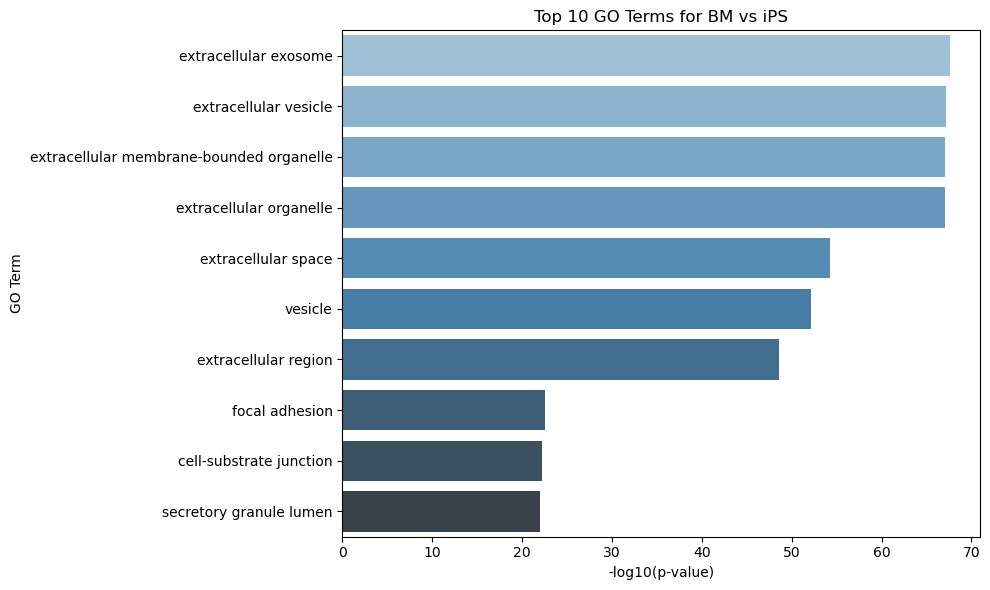

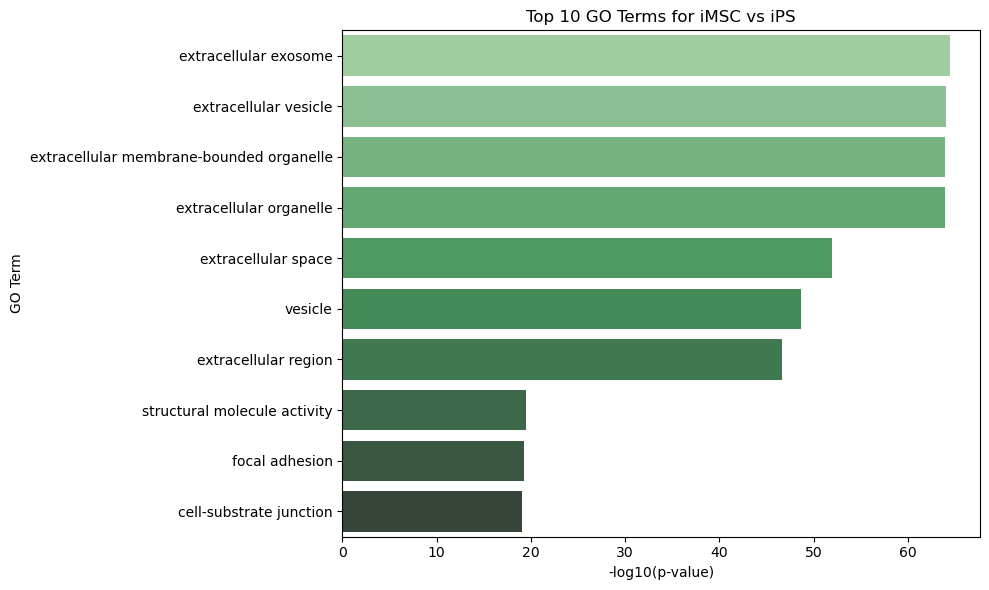

In [14]:

# Plot for BM vs iPS
top_go_terms_BM_iPS = go_results_BM_iPS[['name', 'p_value']].sort_values(by='p_value').head(10)

# Transform p-values to -log10(p-value)
top_go_terms_BM_iPS['-log10_pvalue'] = -np.log10(top_go_terms_BM_iPS['p_value'])

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=top_go_terms_BM_iPS, x='-log10_pvalue', y='name', palette='Blues_d')
plt.title('Top 10 GO Terms for BM vs iPS')
plt.xlabel('-log10(p-value)')
plt.ylabel('GO Term')
plt.tight_layout()
plt.show()

# Plot for iMSC vs iPS
top_go_terms_iMSC_iPS = go_results_iMSC_iPS[['name', 'p_value']].sort_values(by='p_value').head(10)

# Transform p-values to -log10(p-value)
top_go_terms_iMSC_iPS['-log10_pvalue'] = -np.log10(top_go_terms_iMSC_iPS['p_value'])

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=top_go_terms_iMSC_iPS, x='-log10_pvalue', y='name', palette='Greens_d')
plt.title('Top 10 GO Terms for iMSC vs iPS')
plt.xlabel('-log10(p-value)')
plt.ylabel('GO Term')
plt.tight_layout()
plt.show()

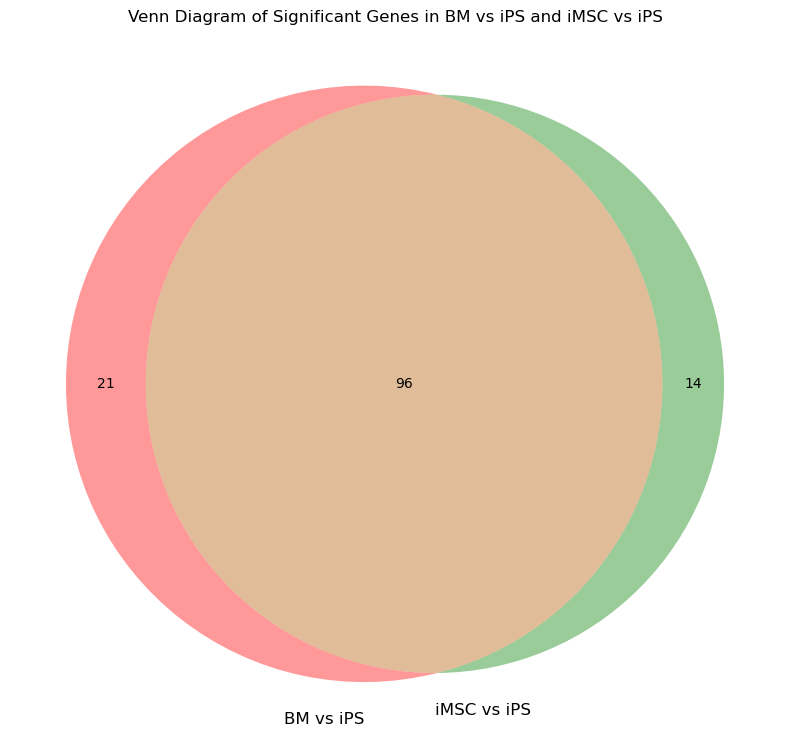

In [15]:
from matplotlib_venn import venn2

# Get the significant proteins for BM vs iPS (p-value < 0.05)
significant_proteins_BM_iPS = significant_proteins[significant_proteins["PValue_BM_iPS"] < 0.05]
significant_proteins_iMSC_iPS = significant_proteins[significant_proteins["PValue_iMSC_iPS"] < 0.05]

# Get the list of significant genes for each comparison
significant_BM_iPS_genes = significant_proteins_BM_iPS.index.tolist()  # BM vs iPS significant genes
significant_iMSC_iPS_genes = significant_proteins_iMSC_iPS.index.tolist()  # iMSC vs iPS significant genes

# Create a Venn diagram for the significant genes
plt.figure(figsize=(8, 8))
venn2([set(significant_BM_iPS_genes), set(significant_iMSC_iPS_genes)], 
      set_labels=('BM vs iPS', 'iMSC vs iPS'))

# Show the plot
plt.title('Venn Diagram of Significant Genes in BM vs iPS and iMSC vs iPS')
plt.tight_layout()
plt.show()
